In [1]:
import numpy as np
from ultralytics import YOLO
import cv2
import cv2 as cv
import os
import matplotlib.pyplot as plt
#from programs.ResNet_Blocks_3D_four_blocks_test import resnet18
from programs.ResNet_Blocks_3D_four_blocks import resnet18
from programs.CustomDataset2 import CustomImageDataset
from programs.CustomDataset2 import padding
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
def bgsubList(folderName, filenames):

    frames = []
    for filename in filenames:
        frame = cv2.imread(folderName + '/' + filename)
        grayImage = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(grayImage)

    frameCount = len(frames)
    nSampFrame = min(np.fix(frameCount / 2), 100)

    # Creating a numpy array of the the sample frames
    firstSampFrame = True
    secondSampFrame = True
    for frameNum in np.fix(np.linspace(1, frameCount, int(nSampFrame))):
        if firstSampFrame:
            firstSampFrame = False
            sampFrames = frames[0]
            continue
        if secondSampFrame:
            secondSampFrame = False
            sampFrames = np.stack((sampFrames, frames[int((frameNum - 1))]), axis=0)
            continue
        sampFrames = np.vstack((sampFrames, np.array([frames[int((frameNum - 1))]])))

    sampFrames.sort(0)

    videobg = sampFrames[int(np.fix(nSampFrame * .9))]

    outputVid = []
    for frame in frames:
        # Subtract foreground from background image by allowing values beyond the 0 to 255 range of uint8
        difference_img = np.int16(videobg) - np.int16(frame)

        # Clip values in [0,255] range
        difference_img = np.clip(difference_img, 0, 255)

        # Convert difference image to uint8 for saving to video
        difference_img = np.uint8(difference_img)
        outputVid.append(difference_img)

    return outputVid

In [3]:
folder = '020116_012/'
files = os.listdir(folder)
files = [fileName for fileName in files if fileName.endswith('.bmp')]
files.sort()

bgsubIms = bgsubList(folder[:-1], files)

#im0 = cv.imread(folder + files[0])
im0 = bgsubIms[0]
print('bgsub done')

bgsub done


In [4]:
yoloWeigths = 'inputs/weights/orthographic_yolo/best.pt'

model = YOLO(yoloWeigths)


In [5]:
#programFiles = os.listdir('inputs/weights/resnet_no_iou/resnet_pose_best_python_230608_four_blocks.pt')
resnetWeights = 'inputs/weights/resnet_no_iou/resnet_pose_best_python_230608_four_blocks.pt'
#resnet = 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnetModel = resnet18(1, 12, activation='leaky_relu').to(device)
resnetModel = nn.DataParallel(resnetModel)
resnetModel.load_state_dict(torch.load( resnetWeights  ))
resnetModel.eval()

n_cuda = torch.cuda.device_count()
if (torch.cuda.is_available()):
    print(str(n_cuda) + 'GPUs are available!')
    nworkers = n_cuda*12
    pftch_factor = 2
else:
    print('Cuda is not available. Training without GPUs. This might take long')
    nworkers = 4
    pftch_factor = 2
batch_size = 512*n_cuda

1GPUs are available!


In [6]:
im0 = bgsubIms[0]
im0 = im0.astype(float)
im0 *= 255 / np.max(im0)
im0 = im0.astype(np.uint8)
print(im0.shape)
im0 = np.stack((im0, im0, im0), axis = 2)
result = model(im0)[0]

(640, 640)



0: 640x640 26 zebrafishbs, 9.2ms
Speed: 5.2ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
def isBoxFarFromEdge(box):
    edgeThreshold = 5
    imageSizeX, imageSizeY = 640, 640
    xDistance = np.min(imageSizeX - box[[0,2]])
    xDistance2 = np.min(box[[0,2]])
    xDistanceMin = min(xDistance, xDistance2)
    yDistance = np.min(imageSizeY - box[[1,3]])
    yDistance2 = np.min(box[[1,3]])
    yDistanceMin = min(yDistance, yDistance2)
    minDist = min(yDistanceMin, xDistanceMin)
    
    return minDist > edgeThreshold 
    

In [8]:
confidence_mask = result.boxes.conf.cpu().numpy() > .5
boxList = result.boxes.xyxy.cpu().numpy()[confidence_mask]
keypointsList = result.keypoints.xy.cpu().numpy()[confidence_mask]
mask = [isBoxFarFromEdge(box) for box in boxList]
boxList = boxList[mask]
keypointsList = keypointsList[mask]

# Let get rid of the boxes which are close to the edge


In [9]:
def drawbox(ax, box):
    sx, sy, bx, by = box
    ax.plot([sx,sx,bx,bx,sx], [sy,by,by,sy,sy], c = 'r')

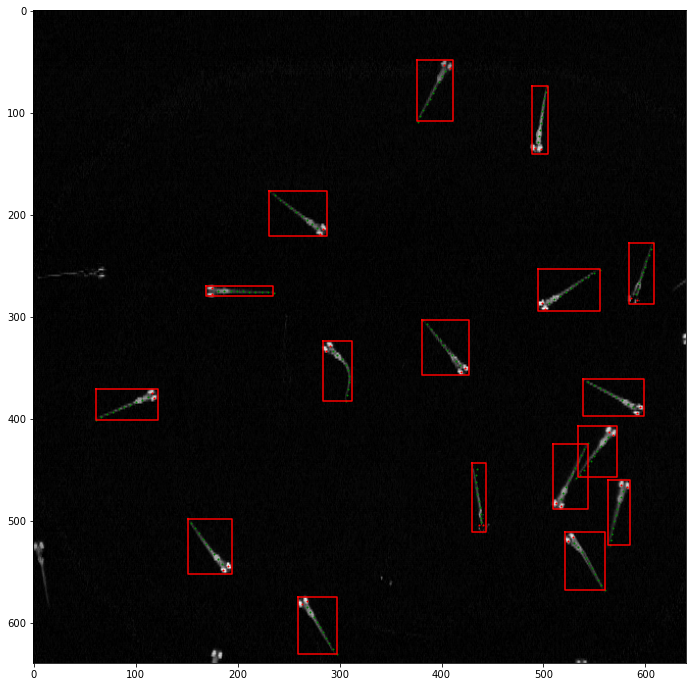

In [10]:
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
ax.imshow(im0)
red = [0,0,255]
green = [0,255, 0]
red = 'r'
green = 'g'

for keypointsIdx, keypoints in enumerate(keypointsList):
    for keypointIdx in range(len(keypoints)):
        keypoint = keypoints[keypointIdx,:]
        color = green if keypointIdx < 10 else red
        ax.scatter(keypoint[0], keypoint[1], c = color, s = 1)
    box = boxList[keypointsIdx]
    drawbox(ax, box)
    
plt.show()

In [11]:
# Getting the cutouts
cutouts = []
for box in boxList:
    sx, sy, bx, by = box.astype(int)
    cutout = im0[sy - 3: by + 4, sx - 3: bx + 4]
    cutout = cutout.astype(float)
    cutout *= 255 / np.max(cutout)
    cutout = cutout.astype(np.uint8)
    cutouts.append(cutout[...,0])

In [12]:
# Preping the resnet data
transform = transforms.Compose([padding(), transforms.PILToTensor() ])
data = CustomImageDataset(cutouts, transform=transform)
loader = DataLoader(data, batch_size=batch_size,shuffle=False,num_workers=nworkers,prefetch_factor=pftch_factor,persistent_workers=True)

In [14]:
smallImageSizeY, smallImageSizeX = 101, 101

for i, im in enumerate(loader):
    im = im.to(device)
    pose_recon = resnetModel(im)

    #pose_recon = pose_recon.detach().cpu().numpy()
    #im = np.squeeze(im.detach().cpu().numpy())

    pose_recon = pose_recon.detach().cpu().numpy()

    im = np.squeeze(im.cpu().detach().numpy(), axis = 1)

correctCoors = []
# Sending back the coordinates to where they came from
for poseIdx in range(pose_recon.shape[0]):
    pose = np.copy(pose_recon[poseIdx])
    box = boxList[poseIdx].astype(int)
    sx, sy, bx, by = box
    width = (bx - sx) + 1
    height = (by - sy) + 1
    w_buffer = smallImageSizeX - width
    w_left = int(w_buffer / 2)
    w_right = w_buffer - w_left
    h_buffer = smallImageSizeY - height
    h_top = int(h_buffer / 2)
    
    pose[0,:] -= w_left
    pose[1,:] -= h_top
    pose[0,:] += sx
    pose[1,:] += sy
    
    correctCoors.append(pose)


In [15]:
def getResnetCoors(cutouts, boxList):
    
    # Preping the resnet data
    transform = transforms.Compose([padding(), transforms.PILToTensor() ])
    data = CustomImageDataset(cutouts, transform=transform)
    loader = DataLoader(data, batch_size=batch_size,shuffle=False,num_workers=nworkers,prefetch_factor=pftch_factor,persistent_workers=True)

    for i, im in enumerate(loader):
        im = im.to(device)
        pose_recon = resnetModel(im)

        #pose_recon = pose_recon.detach().cpu().numpy()
        #im = np.squeeze(im.detach().cpu().numpy())

        pose_recon = pose_recon.detach().cpu().numpy()

        im = np.squeeze(im.cpu().detach().numpy(), axis = 1)

    correctCoors = []
    # Sending back the coordinates to where they came from
    for poseIdx in range(pose_recon.shape[0]):
        pose = np.copy(pose_recon[poseIdx])
        box = boxList[poseIdx].astype(int)
        sx, sy, bx, by = box
        width = (bx - sx) + 1
        height = (by - sy) + 1
        w_buffer = smallImageSizeX - width
        w_left = int(w_buffer / 2)
        w_right = w_buffer - w_left
        h_buffer = smallImageSizeY - height
        h_top = int(h_buffer / 2)

        pose[0,:] -= w_left
        pose[1,:] -= h_top
        pose[0,:] += sx
        pose[1,:] += sy

        correctCoors.append(pose)
    return correctCoors



In [16]:
smallImageSizeY, smallImageSizeX = 101, 101
# Lets do the calculation to see where the fish should be
box0 = np.copy(boxList[0])
pose0 = np.copy(pose_recon[0])
sx, sy, bx, by = box0

width = (bx - sx) + 1
height = (by - sy) + 1
w_buffer = smallImageSizeX - width
w_left = int(w_buffer / 2)
w_right = w_buffer - w_left
h_buffer = smallImageSizeY - height
h_top = int(h_buffer / 2)

# Lets send the coordiante back to the full image
pose0[0,:] -= w_left
pose0[1,:] -= h_top
pose0[0,:] += sx
pose0[1,:] += sy

[        259         575         297         631]


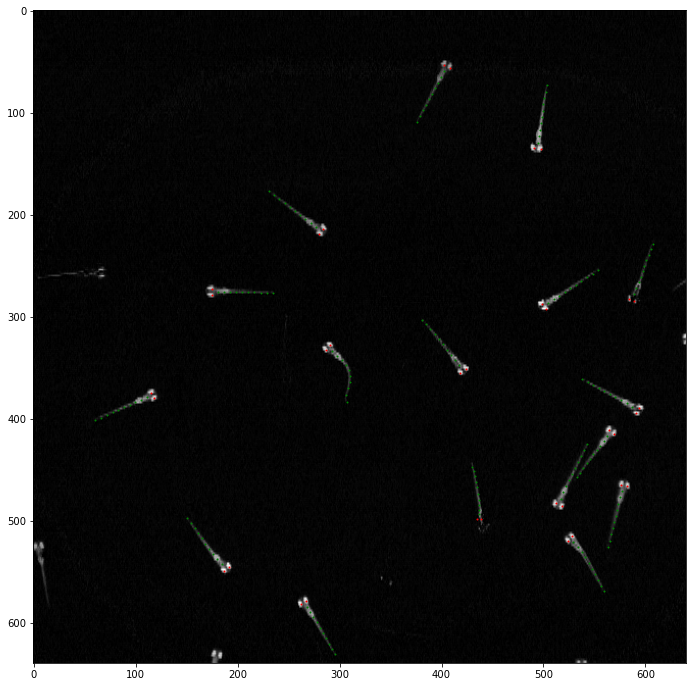

[[      267.6       271.1      274.37      277.41      280.49      283.63      286.76      289.77      292.75      295.81       262.1      267.26]
 [     584.66      589.83      594.85      599.91      604.89      610.09      615.33      620.57      625.87      630.96      582.19      578.66]]


In [17]:
print(boxList[0])

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
ax.imshow(im0)
for pose in correctCoors:
    ax.scatter(pose[0,:10], pose[1,:10], c = 'g', s = 1)
    ax.scatter(pose[0,10:], pose[1,10:], c = 'r', s = 1)
plt.show()
print(correctCoors[0])


In [18]:
# Drawing the poses onto the image
def superimposePoses(im, poses):
    imSup = np.copy(im)
    
    red = [0,0,255]
    green = [0,255,0]

    for pose in poses:
        pose2 = np.copy(pose)
        pose2 = pose.astype(int)
        for pIdx in range(12):
            color = green if pIdx < 10 else red
            imSup = cv.circle(imSup, (pose2[0, pIdx], pose2[1,pIdx]), 2, color, -1)
            
    return imSup

#imSup = superimposePoses(im0, correctCoors)
#fig = plt.figure(figsize = (12,12))
#ax = fig.gca()
#ax.imshow(imSup)
#plt.show()

In [19]:
bgsubIms[0].shape

imageSizeX, imageSizeY = 640, 640
fps = 500
#fps = cap.get( cv.CAP_PROP_FPS )
fourcc = cv.VideoWriter_fourcc('M','J','P','G')
#fourcc = cv.VideoWriter_fourcc(*'DIVX')
#outputPath = 'outputs/superimposed/' + videoName + '.avi'
outputPath = 'video2.avi'
out = cv.VideoWriter(outputPath, fourcc  , int( fps  ) ,(int(imageSizeX) , int( imageSizeY )))

for frameIdx, bgsubIm in tqdm(enumerate(bgsubIms), total = len(bgsubIms)):
    #if frameIdx > 1: break
    im = np.copy(bgsubIm)
    im = im.astype(float)
    im *= 255 / np.max(im)
    im = im.astype(np.uint8)
    
    rgb = np.stack((im, im, im), axis = 2)
    
    result = model(rgb, verbose = False)[0]
    
    confidence_mask = result.boxes.conf.cpu().numpy() > .75
    boxList = result.boxes.xyxy.cpu().numpy()[confidence_mask]
    keypointsList = result.keypoints.xy.cpu().numpy()[confidence_mask]
    mask = [isBoxFarFromEdge(box) for box in boxList]
    boxList = boxList[mask]
    keypointsList = keypointsList[mask]
    
    # Getting the cutouts
    cutouts = []
    for box in boxList:
        sx, sy, bx, by = box.astype(int)
        cutout = bgsubIm[sy - 3: by + 4, sx - 3: bx + 4]
        cutout = cutout.astype(float)
        cutout *= 255 / np.max(cutout)
        cutout = cutout.astype(np.uint8)
        cutouts.append(cutout)
    
    coorList = getResnetCoors(cutouts, boxList)
    res = superimposePoses(np.stack((bgsubIm, bgsubIm, bgsubIm), axis = 2 ), coorList)
    out.write(res)
    
out.release()

100%|██████████| 4977/4977 [28:01<00:00,  2.96it/s]


In [ ]:
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
ax.imshow(res)
plt.show()